In [1]:
from __future__ import division

from utils.prog import log_progress as lp
import statsmodels.formula.api as smf
import matplotlib.colors as mcolors
from numpy import transpose as T
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.api as sm
import scipy.stats as stats
import sklearn.cluster
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import palettable
import scipy
import sys
import os
sys.stdout.write('.')
%matplotlib inline

cols = palettable.tableau.ColorBlind_10.hex_colors
cols += palettable.tableau.PurpleGray_6.hex_colors
cols += palettable.tableau.Tableau_10.hex_colors

CONDIR = os.environ.get("CONDIR")

.

### Read in data

In [2]:
connectomes_gsr_all = np.load(os.path.join(CONDIR,'derivatives/connectomes_gsr.npy'))
connectomes_all = np.load(os.path.join(CONDIR,'derivatives/connectomes.npy'))
results_all = pd.read_csv(os.path.join(CONDIR,'derivatives/connectome_results.csv'))
results_all = results_all.drop('Unnamed: 0',axis=1)
cleantable = pd.read_csv(os.environ.get("CLEANTABLE"))

for idx,row in results_all.iterrows():
    subid = np.where(row.subject==cleantable.UID)
    results_all.set_value(idx,'MRIQC_score',list(cleantable.MRIQC_score.iloc[subid])[0])

In [3]:
print(connectomes_all.shape)
print(len(results_all))
assert(connectomes_all.shape[2]==len(results_all))

(382, 382, 791)
791


In [4]:
# Code to look at raw mean differences between PS and HC
# P = np.where(results_all.patient==888)[0]
# H = np.where(results_all.patient==999)[0]
# Pmn = np.mean(connectomes_all[:,:,P],axis=2)
# Hmn = np.mean(connectomes_all[:,:,H],axis=2)
# dif = Pmn-Hmn
# dif = dif[order,:]
# dif = dif[:,order]
# gordon_network_figure(dif,limits=[-0.1,0.1],
#                       title="difference psychosis - healthy")

### Look at quality measures (without selection)

We have 2 quality measures:
- percentage high-motion time points: we define high-motion time points as points with FD > 0.5mm.
- MRIQC score: based on the T1.  This is of importance for the resting state analyses as to ensure the coregistration is valid.

**Note**: the correlation matrices are based on truncated time series: all time points with high motion, as well as 1 timepoint before and after the high-motion time point are removed.  It has been shown to be a crucial motion cleaning step.
**Note**: if the percentage of timepoints with FD>0.5mm is larger than 20%, then the correlation matrix is not computed.  Those correlation matrices would probably be very invalid.

These results below are before any selection based on quality.

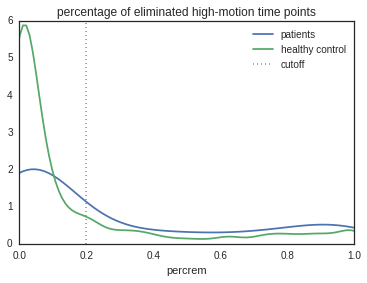

In [5]:
sns.set_style('white')
sns.distplot(results_all.percrem[results_all.patient==888],hist=False,label='patients')
sns.distplot(results_all.percrem[results_all.patient==999],hist=False,label='healthy control')
plt.axvline(x=0.2,color=cols[1],label='cutoff',ls=":")
plt.legend()
plt.xlim([0,1])
plt.title("percentage of eliminated high-motion time points")

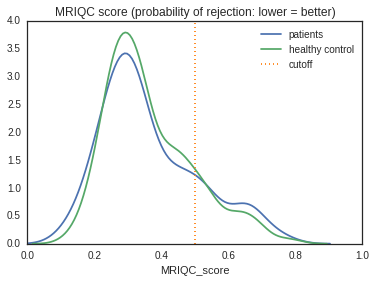

In [6]:
sns.set_style('white')
sns.distplot(results_all.MRIQC_score[results_all.patient==888],hist=False,label='patients')
sns.distplot(results_all.MRIQC_score[results_all.patient==999],hist=False,label='healthy control')
plt.axvline(x=0.5,color=cols[1],label='cutoff',ls=":")
plt.xlim([0,1])
plt.legend()
plt.title("MRIQC score (probability of rejection: lower = better)")

### Covariance between QA and high-motion timepoints

There is some covariance, which is cool because the QC score is based on the T1 and the high-motion timepoints are based on the resting state data.  In the plot below, each point is a resting state dataset.  Only the orange sessions are held for further analyses (unless otherwise specified).

/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


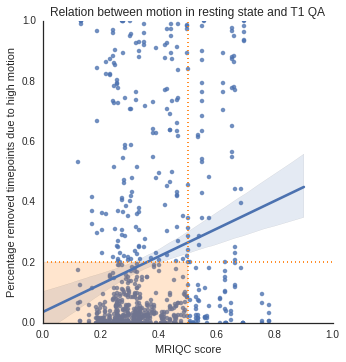

In [7]:
from matplotlib.patches import Rectangle

sns.lmplot(x='MRIQC_score',y='percrem',data=results_all)
plt.axvline(x=0.5,color=cols[1],label='cutoff',ls=":")
plt.axhline(y=0.2,color=cols[1],label='cutoff',ls=":")
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("MRIQC score")
plt.ylabel("Percentage removed timepoints due to high motion")
plt.title("Relation between motion in resting state and T1 QA")
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0,0), 0.5, 0.2, facecolor=cols[1],alpha=0.2))

### Average within networks

Below, we take the average of each network-to-network correlations

In [8]:
labelsfile = os.path.join(os.environ.get("CODEDIR"),"04_connectome/utils/Parcels.xlsx")
labeltable = pd.read_excel(labelsfile)
subprob = range(333,353)
cort = range(353,382)
order = np.argsort(labeltable.Community).tolist()+subprob+cort
labelnames = list(labeltable.Community[order][:333])+['subcort']*20+['cerebellum']*27
labels = np.unique(labelnames)
labelnames_unsorted = list(labeltable.Community)+['subcort']*20+['cerebellum']*27

def get_within_network_connectivity(con):
    con_av = np.zeros([len(labels),len(labels),con.shape[2]])
    idx1 = -1
    for label1 in lp(labels):
        idx1 += 1
        for idx2,label2 in enumerate(labels):
            x1 = np.where(np.array(labelnames_unsorted) == label1)[0]
            x2 = np.where(np.array(labelnames_unsorted) == label2)[0]
            subsel = con[x1,:,:]
            subsel = subsel[:,x2,:]
            if label1==label2: #if within-network connectivity: only average top triangle
                upid = np.triu_indices(len(x1))
                av = np.mean(subsel[upid],axis=0)
            else:
                av = np.mean(subsel,axis=(0,1))
            con_av[idx1,idx2,:] = av
    return con_av

con_av_gsr_all = get_within_network_connectivity(connectomes_gsr_all)
con_av_all = get_within_network_connectivity(connectomes_all)

### What does the average correlation matrix look like (with and without GSR) ?

Here we select the data based on the number of problematic time points.  This is crucial, as the connectomes are (consciously) not computed when too much motion is present.

In [9]:
QAid = np.where(results_all.MOTION_pass==1)[0]
results = results_all.iloc[QAid]
results['patient_bin'] = ['True' if x==888 else 'False' for x in results['patient']]
results.reset_index()
con_av = con_av_all[:,:,QAid]
con_av_gsr = con_av_gsr_all[:,:,QAid]

/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


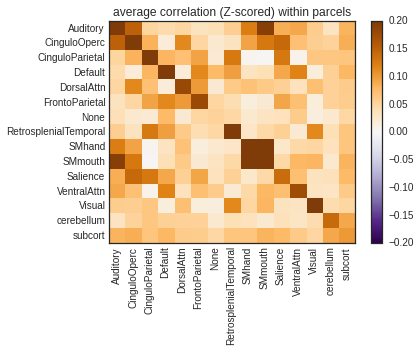

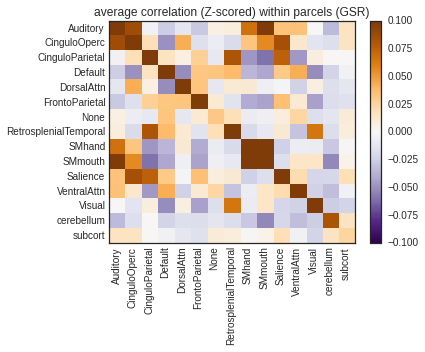

In [10]:
def gordon_network_figure(con,limits=[-0.2,0.2],title="correlation matrix",cmap='PuOr_r'):
    labels_num = np.arange(15)
    major_ticks = np.arange(15)
    minor_ticks = np.arange(15)
    fig = plt.figure(figsize=(6, 5), dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax1 = ax.imshow(con,cmap = cmap,vmin=limits[0],vmax=limits[1],aspect='auto',interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(minor_ticks,minor=True)
    ax.set_xticks([],minor=False)
    ax.set_xticklabels(labels,minor=True,rotation=90)
    ax.set_yticks(minor_ticks,minor=True)
    ax.set_yticks([],minor=False)
    ax.set_yticklabels(labels,minor=True)
    plt.colorbar(ax1)
    plt.tight_layout()

gordon_network_figure(np.mean(con_av,axis=2),limits=[-0.2,0.2],title="average correlation (Z-scored) within parcels")
gordon_network_figure(np.mean(con_av_gsr,axis=2),limits=[-0.1,0.1],title="average correlation (Z-scored) within parcels (GSR)")

In [11]:
# Code to look at raw mean differences between PS and HC
# P = np.where(results.patient==888)[0]
# H = np.where(results.patient==999)[0]
# Pmn = np.mean(con_av[:,:,P],axis=2)
# Hmn = np.mean(con_av[:,:,H],axis=2)
# dif = Pmn-Hmn
# gordon_network_figure(dif,limits=[-0.05,0.05],
#                       title="difference psychosis - healthy (no gsr)")
# Pmn = np.mean(con_av_gsr[:,:,P],axis=2)
# Hmn = np.mean(con_av_gsr[:,:,H],axis=2)
# dif = Pmn-Hmn
# gordon_network_figure(dif,limits=[-0.05,0.05],
#                       title="difference psychosis - healthy (gsr)")

### Mass univariate comparison

Below, I'm doing a mass univariate comparison between the two groups in a linear mixed model (random intercept per subject).

In [12]:
labels = np.unique(labelnames).tolist()

avT_gsr = np.zeros([len(labels),len(labels)])
avP_gsr = np.zeros([len(labels),len(labels)])
avmat = np.zeros([len(labels),len(labels)])

def compare_connectomes(connectome,X,groups):
    avT = np.zeros([len(labels),len(labels)])
    avP = np.zeros([len(labels),len(labels)])
    idx1 = -1
    for label1 in lp(labels):
        idx1 += 1
        for idx2,label2 in enumerate(labels):
            if idx2>idx1:
                avT[idx1,idx2]=avT[idx2,idx1]
                avP[idx1,idx2]=avP[idx2,idx1]
            av = connectome[idx1,idx2]
            data = pd.DataFrame({"val":av,"X":X,"subject":groups})
            fit = smf.mixedlm('val ~ X',data=data,groups=data.subject).fit()
            avT[idx1,idx2] = -fit.tvalues['X']
            avP[idx1,idx2] = fit.pvalues['X']
    return avT, avP

patient = [1 if x==999 else 0 for x in results.patient]
AvT, AvP = compare_connectomes(con_av,patient,results.subject)
AvT_gsr, AvP_gsr = compare_connectomes(con_av_gsr,patient,results.subject)

/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/statsmodels/regression

Below the results can be seen.  The distribution of the T-values with global signal regression is a lot wider.  This indicates that the variance within the groups (and or within subjects) diminishes, which increases the estimated variance between the groups.  This indicates that the global signal regression indeed removes **a lot** of nuisance, and we win power.

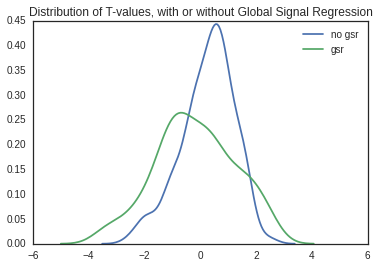

In [13]:
sns.distplot(AvT.flatten(),hist=False,label='no gsr')
sns.distplot(AvT_gsr.flatten(),hist=False,label="gsr")
plt.title("Distribution of T-values, with or without Global Signal Regression")

Below are the T-maps of the connectomes.  It shows that indeed the patterns are similar, but much stronger.

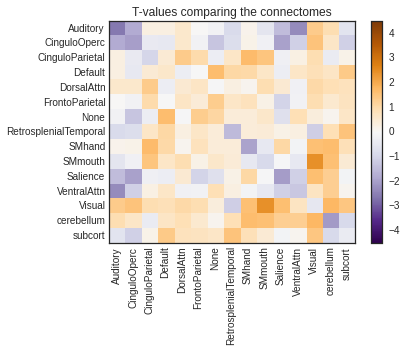

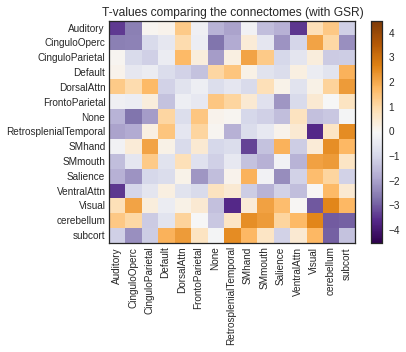

In [14]:
gordon_network_figure(AvT,limits=[-4.5,4.5],title="T-values comparing the connectomes")
gordon_network_figure(AvT_gsr,limits=[-4.5,4.5],title="T-values comparing the connectomes (with GSR)")

### Threshold with Benjamini-Hochberg

In [15]:
def compute_BH_threshold(pmap):
    upid = np.triu_indices(pmap.shape[0])
    pvals = pmap[upid]
    hlp = np.argsort(pvals)/len(pvals)*0.05
    bhpthres = np.max(pvals[pvals<hlp])
    return bhpthres

pthres = compute_BH_threshold(AvP)
tthres = np.min(np.abs(AvT[AvP<pthres]))
pthres_gsr = compute_BH_threshold(AvP_gsr)
tthres_gsr = np.min(np.abs(AvT_gsr[AvP_gsr<pthres]))

In [16]:
print("significance threshold: no gsr: %f - gsr: %f"%(tthres,tthres_gsr))

significance threshold: no gsr: 2.290226 - gsr: 2.451784


In [17]:
def make_cmap(limit,threshold):
    thr = (threshold/limit)/2.+0.5
    upper = thr
    lower = 1-upper
    cmap1 =  {'blue': 
     [[0.0, None, 0.9019607843137255], 
      [lower, 0.4392156862745098, 0.9607843137254902], 
      [upper, 0.8274509803921568, 0.24705882352941178], 
      [1.0, 0.0, None]], 
     'green': 
     [[0.0, None, 0.8470588235294118], 
      [lower, 0.09803921568627451, 0.9607843137254902], 
      [upper, 0.8274509803921568, 0.5215686274509804], 
      [1.0, 0.8431372549019608, None]], 
     'red': 
     [[0.0, None, 0.6784313725490196], 
      [lower, 0.09803921568627451, 0.9607843137254902], 
      [upper, 0.8274509803921568, 0.803921568627451], 
      [1.0, 1.0, None]]}
    cmap = mcolors.LinearSegmentedColormap("CustomMap",cmap1)
    return cmap

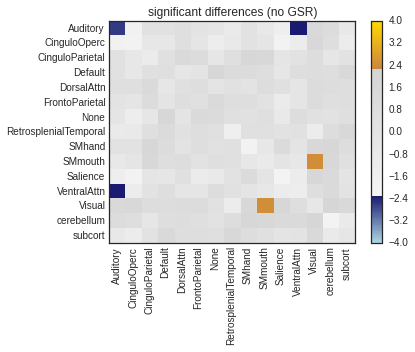

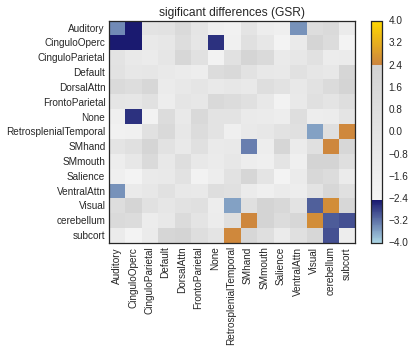

In [18]:
cmap = make_cmap(limit=4,threshold=tthres)
gordon_network_figure(AvT,title='significant differences (no GSR)',limits=[-4,4],cmap=cmap)
cmap = make_cmap(limit=4,threshold=tthres_gsr)
gordon_network_figure(AvT_gsr,title='sigificant differences (GSR)',limits=[-4,4],cmap=cmap)

## What does it look like after MRIQC

In [19]:
# subset results --> this HAS TO BE DONE, as no motion pass ==> con = 0
QAid = np.where(np.logical_and(results.MRIQC_pass==1,results.MOTION_pass==1))[0]
results = results_all.iloc[QAid]
results_all['patient_bin'] = ['True' if x==888 else 'False' for x in results_all['patient']]
results_all.reset_index()

connectomes_gsr = connectomes_gsr_all[:,:,QAid]
connectomes = connectomes_all[:,:,QAid]
con_av_gsr = get_within_network_connectivity(connectomes_gsr)
con_av = get_within_network_connectivity(connectomes)

#con_av = con_av[:,:,QAid]

In [20]:
patient = [1 if x==999 else 0 for x in results.patient]
AvT_qc, AvP_qc = compare_connectomes(con_av,patient,results.subject)
AvT_gsr_qc, AvP_gsr_qc = compare_connectomes(con_av_gsr,patient,results.subject)

/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/statsmodels/regression

In [21]:
pthres = compute_BH_threshold(AvP_qc)
tthres = np.min(np.abs(AvT_qc[AvP_qc<pthres]))
pthres_gsr = compute_BH_threshold(AvP_gsr_qc)
tthres_gsr = np.min(np.abs(AvT_gsr_qc[AvP_gsr_qc<pthres]))

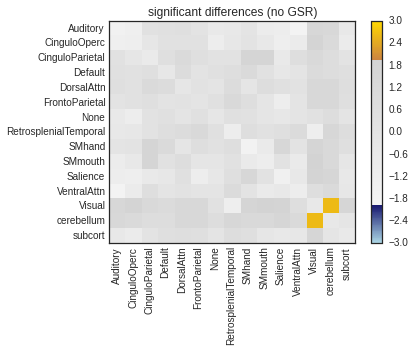

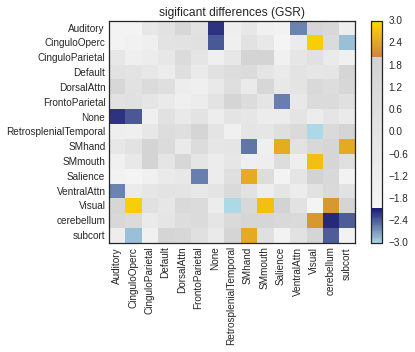

In [22]:
cmap = make_cmap(limit=4,threshold=tthres)
gordon_network_figure(AvT_qc,title='significant differences (no GSR)',limits=[-3,3],cmap=cmap)
cmap = make_cmap(limit=4,threshold=tthres_gsr)
gordon_network_figure(AvT_gsr_qc,title='sigificant differences (GSR)',limits=[-3,3],cmap=cmap)